<a href="https://colab.research.google.com/github/2024S-Ajou-ML-pandastic4/whaccent/blob/master/WACNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchaudio

import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms as AT
import matplotlib.pyplot as plt

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install datasets librosa

from datasets import load_dataset, DatasetDict, Audio
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import librosa
import numpy as np

# 데이터셋 로드
dataset_name = "iisking/waccent"
dataset = DatasetDict()

dataset["train"] = load_dataset(dataset_name, split="train")
dataset["validation"] = load_dataset(dataset_name, split="validatoin") # 오타 수정
dataset["test"] = load_dataset(dataset_name, split="test")
print(dataset)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.3 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12600 [00:00<?, ? examples/s]

Generating validatoin split:   0%|          | 0/3618 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1782 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['filename', 'text', 'accent', 'duration', '__index_level_0__'],
        num_rows: 12600
    })
    validation: Dataset({
        features: ['filename', 'text', 'accent', 'duration', '__index_level_0__'],
        num_rows: 3618
    })
    test: Dataset({
        features: ['filename', 'text', 'accent', 'duration', '__index_level_0__'],
        num_rows: 1782
    })
})


In [ ]:
import os
import time
import shutil
import pandas as pd
from tqdm import tqdm

In [ ]:

from torchvision import datasets
from torchvision.transforms import v2

In [ ]:
print(dataset["train"][0]["filename"])
print(len(dataset["train"][0]["filename"]["array"]))

{'path': 'sample-086904.mp3', 'array': array([ 0.00000000e+00, -8.35235134e-15, -7.95493872e-15, ...,
        3.18146078e-07,  1.51354641e-06, -1.63861444e-07]), 'sampling_rate': 48000}
168192


In [ ]:
# 오디오 데이터셋으로 변환
dataset = dataset.cast_column("filename", Audio(sampling_rate=16000))

# 라벨을 숫자로 변환하기 위한 맵핑
accent_to_label = {accent: idx for idx, accent in enumerate(set(dataset["train"]["accent"]))}

In [ ]:
print(accent_to_label)

{'KR': 0, 'indian': 1, 'us': 2, 'canada': 3, 'england': 4, 'australia': 5}


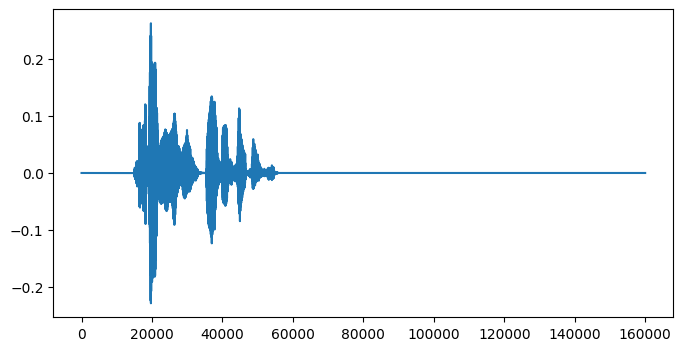

In [ ]:

#하나의 음성데이터 시각화

audio = dataset["train"][0]["filename"]["array"]
audio = torch.tensor(audio).float()

#패딩
pad_size = 160000 - audio.shape[0]
audio = torch.nn.functional.pad(audio, (0, pad_size))

audio = audio.reshape(1, -1) #torch.tensor (1,n)

_, ax = plt.subplots(1,1, figsize = (8,4))
ax.plot(audio[0, :])
plt.show()


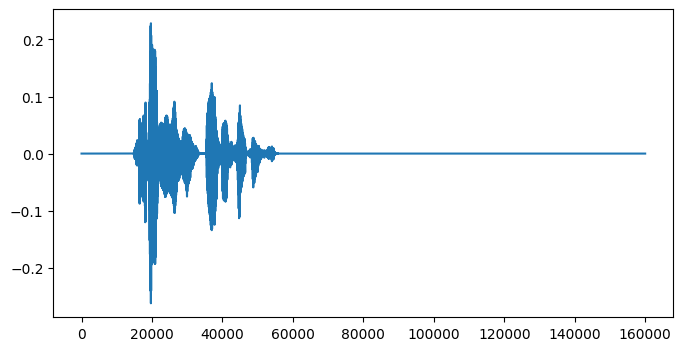

In [ ]:
#data augmentation 1: # 위상을 뒤집는 것으로서 원래 소리와 똑같이 들린다.
temp_numpy = (-1)*audio

_, ax = plt.subplots(1,1, figsize = (8,4))
ax.plot(temp_numpy[0, :])
plt.show()


In [ ]:
#멜 스펙트로그램 변환기
sr = 16000
win_length = int(np.ceil(0.025 * sr))
#n_fft = int(np.ceil(0.025 * sr))
n_fft=512
hop_length = int(np.ceil(0.01 * sr))

melspectrogram = nn.Sequential(
     AT.MelSpectrogram(
     sample_rate=sr,
     n_fft=n_fft,
     win_length=win_length,
     hop_length=hop_length,
     n_mels=120 #주파수 방향 성분수
     ),
     AT.AmplitudeToDB()
)


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (120) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [ ]:

class CustomDataset(Dataset):
    def __init__(self, hf_dataset, accent_to_label, max_length=16000 * 8):
        self.dataset = hf_dataset
        self.accent_to_label = accent_to_label
        self.max_length = max_length  # 최대 길이를 설정

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        audio = item["filename"]["array"]
        accent = item["accent"]

        # 라벨을 숫자로 변환
        label = self.accent_to_label[accent]

        # 오디오 데이터를 텐서로 변환
        audio = torch.tensor(audio).float()

        # 오디오 길이를 max_length로 패딩 또는 잘라내기
        if audio.shape[0] > self.max_length:
            audio = audio[:self.max_length]
        else:
            pad_size = self.max_length - audio.shape[0]
            audio = torch.nn.functional.pad(audio, (0, pad_size))

        # 오디오 데이터를 전치
        audio = audio.reshape(1, -1)
        # 오디오 데이터를 멜 스펙트로그램으로 변환
        mel = melspectrogram(audio)

        return mel, label



In [ ]:

# 데이터셋 및 데이터로더 생성
train_dataset = CustomDataset(dataset["train"], accent_to_label)
val_dataset = CustomDataset(dataset["validation"], accent_to_label)
test_dataset = CustomDataset(dataset["test"], accent_to_label)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

#train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
#val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
#test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)


In [ ]:

sample_features, sample_labels = next(iter(train_loader))
print(f"Feature batch shape: {sample_features.size()}")
print(f"Labels batch shape: {sample_labels.size()}")

Feature batch shape: torch.Size([64, 1, 120, 801])
Labels batch shape: torch.Size([64])


In [ ]:
print(sample_features[31])

tensor([[[-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
          -100.0000],
         [-100.0000,  -98.8573,  -78.0017,  ..., -100.0000, -100.0000,
          -100.0000],
         [-100.0000, -100.0000,  -87.7314,  ..., -100.0000, -100.0000,
          -100.0000],
         ...,
         [-100.0000, -100.0000,  -98.0350,  ..., -100.0000, -100.0000,
          -100.0000],
         [-100.0000, -100.0000, -100.0000,  ..., -100.0000, -100.0000,
          -100.0000],
         [-100.0000, -100.0000,  -96.9462,  ..., -100.0000, -100.0000,
          -100.0000]]])


In [ ]:
#cnn 모델 구축
import torch
import torch.nn as nn
import torch.nn.functional as F

class WaCNN(nn.Module):
    def __init__(self):
        super(WaCNN, self).__init__()

        #===============================================#

        #데이터가 channel이 1개인 음성파일이므로 input channel 수 1
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3)

        self.pool = nn.MaxPool2d(2,2)

        self.conv2 = nn.Conv2d(64,128,kernel_size=3)

        self.conv3 = nn.Conv2d(128,128,kernel_size=3)

        self.fc1 = nn.Linear(128 * 13 * 98, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 6)

        #===============================================#

        #conv1 layer뒤에 배치될 batch normalization
        self.bn1 = nn.BatchNorm2d(64)

        #conv2 layer뒤에 배치될 batch normalization
        self.bn2 = nn.BatchNorm2d(128)

        #conv3 layer뒤에 배치될 batch normalization
        self.bn3 = nn.BatchNorm2d(128)

        #dropout은 conv layer보다 fc layer에서 더 효과적이므로 여기다만 배치
        #fc1과 fc2뒤에 각각 배치될 droupout
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)

        #===============================================#

    def forward(self, x):

        #===============================================#
        x = self.pool(self.bn1(self.conv1(x)))
        x = self.pool(self.bn2(self.conv2(x)))
        x = self.pool(self.bn3(self.conv3(x)))
        x = torch.flatten(x,1)

        x = F.relu(self.fc1(x))
        x = self.dropout1(x)

        x = F.relu(self.fc2(x))
        x = self.dropout2(x)

        #x = F.softmax(self.fc3(x))
        x = self.fc3(x)
        #===============================================#

        return x

In [ ]:
WaCNNmodel = WaCNN()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#WaCNNmodel.to(device) # GPU로 올리기
#print(WaCNNmodel)

In [ ]:
WaCNNmodel.cuda()

WaCNN(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=163072, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=6, bias=True)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
)

In [ ]:
#hyperparameter 설정
import torch.optim as optim

EPOCHS = 50
logs = {"train_loss":[] , "train_acc":[] , "val_loss":[] , "val_acc":[]}

if os.path.exists('checkpoints') == False:
    os.mkdir('checkpoints')

criterion = nn.CrossEntropyLoss() # loss function

#==============================#
optimizer = optim.Adam(WaCNNmodel.parameters(), lr=0.001)
#optimizer = optim.SGD(WaCNNmodel.parameters(), lr=0.001, momentum=0.9) # optimizer
Cosine_lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                        lr_lambda=lambda epoch: 0.95 ** epoch)
#==============================#

patience = 10
counter = 0
best_loss = np.inf



In [ ]:
#학습
def train(dataloader , model , loss_fn , optimizer , lr_scheduler=None):
    size = 0
    num_batches = len(dataloader)

    model.train()
    epoch_loss , epoch_correct = 0 , 0

    for i ,(data_ , target_) in enumerate(dataloader):

        #===================================================#
        #gpu로 데이터 이동
        data_, target_ = data_.cuda(), target_.cuda()

        #gradient 초기화
        optimizer.zero_grad()

        #predict 수행
        pred = model(data_)

        #loss function 값 계산
        loss = loss_fn(pred, target_)

        #backpropagation 수행해 gradient 계산
        loss.backward()

        #weight와 bias update
        optimizer.step()

        #전체 training data 갯수 구하기 위해 현재 batch의 data 갯수를 size에 누적
        size += len(data_)

        #epoch_correct값 update
        prednums = pred.max(1)[1] #pred에서 행별로 가장 값이 큰 인덱스 뽑아내기. 그게 곧 예상하는 숫자 label
        epoch_correct += prednums.eq(target_).sum().item() #예상한 숫자 label tensor와 실제 정답 label tensor를 비교해 true의 갯수를 세서 누적

        #epoch_loss값 update
        epoch_loss += loss.item()

        #===================================================#

    if lr_scheduler != None:
        lr_scheduler.step()

    return epoch_correct/size , epoch_loss / num_batches

In [ ]:
#test
from sklearn.metrics import confusion_matrix


def test(dataloader , model , loss_fn):
    size = 0
    num_baches = len(dataloader)
    epoch_loss , epoch_correct= 0 ,0

    # 클래스 개수 정의 (6개의 클래스)
    num_classes = 6
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    with torch.no_grad(): # grad 연산 X
        model.eval() # evaluation dropout 연산시
        for i, (data_ , target_) in enumerate(dataloader):

            #========================================#
            #gpu로 데이터 이동
            data_, target_ = data_.cuda(), target_.cuda()

            #predict 수행
            pred = model(data_)

            softmaxpred = F.softmax(pred, dim=1)
            softmaxpred *= 100

            #loss function 값 계산
            loss = loss_fn(pred, target_)

            #전체 validation data 갯수 구하기 위해 현재 batch의 data 갯수를 size에 누적
            size += len(data_)

            #epoch_correct값 update
            prednums = pred.max(1)[1] #pred에서 행별로 가장 값이 큰 인덱스 뽑아내기. 그게 곧 예상하는 숫자 label
            epoch_correct += prednums.eq(target_).sum().item() #예상한 숫자 label tensor와 실제 정답 label tensor를 비교해 true의 갯수를 세서 누적

            #epoch_loss값 update
            epoch_loss += loss.item()

            # Confusion Matrix 업데이트
            conf_matrix += confusion_matrix(target_.cpu(), prednums.cpu(), labels=np.arange(num_classes))

            #========================================#

    return epoch_correct/size  , epoch_loss / num_baches, conf_matrix

In [ ]:
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   WaCNNmodel ,
                                   criterion ,
                                   optimizer ,
                                   Cosine_lr_scheduler)

    val_acc , val_loss , valimatrix= test(val_loader , WaCNNmodel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    print(valimatrix)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(WaCNNmodel.state_dict() , "checkpoints/Improved_CNN_best.pth")
    else:
        counter+=1
    if counter >= patience:
        test_acc , test_loss, testmatrix = test(test_loader , WaCNNmodel , criterion)
        print("Early stop !")
        print(test_acc)
        print(testmatrix)
        break

  2%|▏         | 1/50 [05:27<4:27:40, 327.77s/it]

epoch:0     train_loss = 1.3112 , train_acc:0.3725     val_loss = 1.3245 , val_acc:0.4024     learning rate: 0.00044012666865176535
[[109 418  62   0   0   3]
 [ 81 497  21   2   0   2]
 [ 87 268 249   0   0   1]
 [ 83 504  20   2   0   0]
 [ 97 476  33   1   0   0]
 [  0   0   0   3   0 599]]
epoch:1     train_loss = 1.2998 , train_acc:0.3760     val_loss = 1.2875 , val_acc:0.4074     learning rate: 0.0004181203352191771
[[ 45 474  71   0   0   2]
 [ 20 540  41   1   1   0]
 [ 43 274 287   0   0   1]
 [ 35 543  30   1   0   0]
 [ 21 539  47   0   0   0]
 [  0   1   0   0   0 601]]


  4%|▍         | 2/50 [10:51<4:20:19, 325.40s/it]

epoch:2     train_loss = 1.2882 , train_acc:0.3853     val_loss = 1.2664 , val_acc:0.4052     learning rate: 0.0003972143184582182
[[ 48 444  59   1  39   1]
 [ 33 510  34   0  26   0]
 [ 63 233 285   1  23   0]
 [ 46 496  36   0  31   0]
 [ 34 508  38   0  27   0]
 [  0   6   0   0   0 596]]


  8%|▊         | 4/50 [21:19<4:03:24, 317.48s/it]

epoch:3     train_loss = 1.2947 , train_acc:0.3838     val_loss = 1.3058 , val_acc:0.3809     learning rate: 0.00037735360253530727
[[  5   0  14   7 565   1]
 [  1   0   4   5 593   0]
 [ 10   1 185   5 404   0]
 [  2   0   7   4 596   0]
 [  3   0   8   5 591   0]
 [  2   6   0   0   1 593]]


 10%|█         | 5/50 [26:29<3:56:11, 314.93s/it]

epoch:4     train_loss = 1.2792 , train_acc:0.3930     val_loss = 1.2695 , val_acc:0.4027     learning rate: 0.0003584859224085419
[[ 46 498  45   0   0   3]
 [ 23 564  14   0   0   2]
 [ 69 289 246   0   0   1]
 [ 20 576  13   0   0   0]
 [ 32 558  17   0   0   0]
 [  0   1   0   0   0 601]]


 12%|█▏        | 6/50 [31:41<3:50:14, 313.96s/it]

epoch:5     train_loss = 1.2748 , train_acc:0.3937     val_loss = 1.2825 , val_acc:0.4002     learning rate: 0.0003405616262881148
[[ 14  31  47   0 498   2]
 [  4  16  18   1 563   1]
 [ 31  32 256   0 285   1]
 [  9  21  16   0 563   0]
 [  7  13  26   0 561   0]
 [  0   0   0   0   1 601]]


 14%|█▍        | 7/50 [36:55<3:44:48, 313.70s/it]

epoch:6     train_loss = 1.2650 , train_acc:0.3925     val_loss = 1.2694 , val_acc:0.4113     learning rate: 0.000323533544973709
[[ 62   0  48   1 479   2]
 [ 52   0  16   0 533   2]
 [ 92   0 280   0 232   1]
 [ 54   0  19   0 536   0]
 [ 38   0  23   0 546   0]
 [  0   0   0   1   1 600]]
epoch:7     train_loss = 1.2625 , train_acc:0.3990     val_loss = 1.2577 , val_acc:0.4196     learning rate: 0.00030735686772502356
[[ 48  29  92   0 420   3]
 [ 41  26  48   0 487   1]
 [ 54  25 348   0 177   1]
 [ 39  27  46   0 497   0]
 [ 29  22  61   0 495   0]
 [  0   0   0   0   1 601]]


 18%|█▊        | 9/50 [47:22<3:34:09, 313.41s/it]

epoch:8     train_loss = 1.2543 , train_acc:0.4048     val_loss = 1.2703 , val_acc:0.4093     learning rate: 0.0002919890243387724
[[ 56  13  30   0 490   3]
 [ 20  13  10   0 557   3]
 [ 87  15 260   0 242   1]
 [ 22  11  12   0 564   0]
 [ 34   8  14   0 551   0]
 [  1   0   0   0   0 601]]


 20%|██        | 10/50 [52:32<3:28:20, 312.52s/it]

epoch:9     train_loss = 1.2360 , train_acc:0.4071     val_loss = 1.2580 , val_acc:0.4234     learning rate: 0.00027738957312183375
[[ 93   0  69   0 427   3]
 [ 66   0  32   3 501   1]
 [109   0 322   0 173   1]
 [ 83   0  19   2 505   0]
 [ 63   0  29   1 514   0]
 [  0   0   0   0   1 601]]


 22%|██▏       | 11/50 [57:43<3:22:45, 311.93s/it]

epoch:10     train_loss = 1.2381 , train_acc:0.4133     val_loss = 1.2690 , val_acc:0.4218     learning rate: 0.00026352009446574203
[[102  41 109   0 337   3]
 [ 92  31  58   0 420   2]
 [ 88  33 373   0 110   1]
 [102  45  42   1 419   0]
 [106  37  46   0 418   0]
 [  0   0   0   0   1 601]]
epoch:11     train_loss = 1.2154 , train_acc:0.4171     val_loss = 1.2421 , val_acc:0.4279     learning rate: 0.00025034408974245495
[[ 88 386 115   1   0   2]
 [ 67 469  65   0   1   1]
 [ 79 135 390   0   0   1]
 [ 69 481  59   0   0   0]
 [ 61 481  65   0   0   0]
 [  0   1   0   0   0 601]]


 26%|██▌       | 13/50 [1:08:08<3:12:18, 311.85s/it]

epoch:12     train_loss = 1.2162 , train_acc:0.4209     val_loss = 1.2448 , val_acc:0.4284     learning rate: 0.00023782688525533216
[[ 80  25  61   1 423   2]
 [ 48  21  19   0 515   0]
 [ 89  13 324   0 178   1]
 [ 54  19  21   0 515   0]
 [ 30  21  30   0 526   0]
 [  2   0   0   0   1 599]]


 28%|██▊       | 14/50 [1:13:18<3:06:50, 311.40s/it]

epoch:13     train_loss = 1.2193 , train_acc:0.4232     val_loss = 1.2440 , val_acc:0.4315     learning rate: 0.00022593554099256555
[[ 95  24 109   2 361   1]
 [ 74  20  51   0 457   1]
 [ 87  11 378   0 128   1]
 [ 89  21  48   0 451   0]
 [ 66  19  54   0 468   0]
 [  0   1   0   0   1 600]]
epoch:14     train_loss = 1.1976 , train_acc:0.4343     val_loss = 1.2354 , val_acc:0.4306     learning rate: 0.00021463876394293727
[[ 76   8  48   2 457   1]
 [ 47   5  19   0 532   0]
 [ 90   5 326   0 183   1]
 [ 45   7  14   0 543   0]
 [ 32   4  21   0 550   0]
 [  0   0   0   0   1 601]]


 30%|███       | 15/50 [1:18:32<3:02:10, 312.31s/it]

epoch:15     train_loss = 1.1930 , train_acc:0.4343     val_loss = 1.2344 , val_acc:0.4348     learning rate: 0.00020390682574579038
[[ 87   0  70   2 432   1]
 [ 44   2  34   0 523   0]
 [ 78   0 355   0 171   1]
 [ 55   0  22   0 532   0]
 [ 49   0  30   0 528   0]
 [  0   0   0   0   1 601]]


 34%|███▍      | 17/50 [1:29:01<2:52:12, 313.09s/it]

epoch:16     train_loss = 1.1909 , train_acc:0.4339     val_loss = 1.2351 , val_acc:0.4265     learning rate: 0.00019371148445850088
[[ 88   1  37   1 464   1]
 [ 52   1  16   0 534   0]
 [101   0 305   0 198   1]
 [ 52   0   7   0 550   0]
 [ 38   0  17   0 552   0]
 [  0   4   0   0   1 597]]
epoch:17     train_loss = 1.1828 , train_acc:0.4385     val_loss = 1.2208 , val_acc:0.4342     learning rate: 0.00018402591023557584
[[105   3  45   0 438   1]
 [ 55  12  15   0 521   0]
 [119   0 318   0 167   1]
 [ 72   0  12   0 525   0]
 [ 49   0  19   0 539   0]
 [  0   4   0   0   1 597]]


 38%|███▊      | 19/50 [1:40:06<2:45:48, 320.93s/it]

epoch:18     train_loss = 1.1723 , train_acc:0.4452     val_loss = 1.2219 , val_acc:0.4386     learning rate: 0.000174824614723797
[[100   9  51   7 424   1]
 [ 60  26  18   3 495   1]
 [ 99   0 338   2 165   1]
 [ 69   3  17   2 518   0]
 [ 56   4  26   0 521   0]
 [  0   1   0   0   1 600]]
epoch:19     train_loss = 1.1693 , train_acc:0.4458     val_loss = 1.2192 , val_acc:0.4428     learning rate: 0.00016608338398760718
[[131   7  51   0 402   1]
 [ 72  27  19   0 484   1]
 [130   0 336   0 138   1]
 [ 92   2  15   0 500   0]
 [ 76   3  21   0 507   0]
 [  0   0   0   0   1 601]]


 42%|████▏     | 21/50 [1:50:32<2:32:58, 316.50s/it]

epoch:20     train_loss = 1.1603 , train_acc:0.4487     val_loss = 1.2252 , val_acc:0.4514     learning rate: 0.0001577792147882268
[[138   8  89   0 356   1]
 [ 88  25  33   0 457   0]
 [107   0 388   0 109   1]
 [ 92   1  36   0 480   0]
 [ 88   3  34   0 482   0]
 [  0   1   0   0   1 600]]


 44%|████▍     | 22/50 [1:55:44<2:27:02, 315.08s/it]

epoch:21     train_loss = 1.1498 , train_acc:0.4558     val_loss = 1.2193 , val_acc:0.4577     learning rate: 0.00014989025404881545
[[158  13  68   0 352   1]
 [104  36  21   0 442   0]
 [117   0 376   0 111   1]
 [132   2  25   0 450   0]
 [ 87   4  30   0 486   0]
 [  0   1   0   0   1 600]]
epoch:22     train_loss = 1.1469 , train_acc:0.4551     val_loss = 1.2191 , val_acc:0.4450     learning rate: 0.00014239574134637466
[[ 94  11  52   0 434   1]
 [ 50  35  13   0 505   0]
 [ 95   0 340   0 169   1]
 [ 64   4  14   0 527   0]
 [ 42   3  20   0 542   0]
 [  0   2   0   0   1 599]]


 48%|████▊     | 24/50 [2:06:10<2:16:07, 314.13s/it]

epoch:23     train_loss = 1.1396 , train_acc:0.4586     val_loss = 1.3166 , val_acc:0.4514     learning rate: 0.00013527595427905592
[[143  14  71   0 362   2]
 [ 85  38  29   0 449   2]
 [ 98   1 374   0 131   1]
 [132   5  30   1 441   0]
 [ 99   2  28   0 476   2]
 [  0   1   0   0   0 601]]


 50%|█████     | 25/50 [2:11:19<2:10:15, 312.63s/it]

epoch:24     train_loss = 1.1387 , train_acc:0.4629     val_loss = 1.2484 , val_acc:0.4533     learning rate: 0.00012851215656510312
[[166   8  71   4 342   1]
 [ 95  40  19   2 447   0]
 [135   0 363   1 105   1]
 [127   1  22   5 454   0]
 [103   2  30   6 466   0]
 [  0   1   0   0   1 600]]


 52%|█████▏    | 26/50 [2:16:29<2:04:43, 311.80s/it]

epoch:25     train_loss = 1.1181 , train_acc:0.4725     val_loss = 1.2397 , val_acc:0.4544     learning rate: 0.00012208654873684796
[[139  12  46   0 394   1]
 [ 61  52  14   0 476   0]
 [119   0 336   0 149   1]
 [ 79   3  13   0 514   0]
 [ 67   2  20   0 518   0]
 [  0   2   0   0   1 599]]


 54%|█████▍    | 27/50 [2:21:40<1:59:26, 311.57s/it]

epoch:26     train_loss = 1.1089 , train_acc:0.4802     val_loss = 1.2401 , val_acc:0.4511     learning rate: 0.00011598222130000556
[[128  11  48   0 404   1]
 [ 66  63  12   0 462   0]
 [138   1 325   0 140   1]
 [ 89   4  12   0 504   0]
 [ 70   3  17   0 517   0]
 [  0   2   0   0   1 599]]


 56%|█████▌    | 28/50 [2:26:50<1:54:06, 311.18s/it]

epoch:27     train_loss = 1.0899 , train_acc:0.4902     val_loss = 1.2385 , val_acc:0.4608     learning rate: 0.00011018311023500529
[[141  20  49   2 379   1]
 [ 59  77  13   1 452   1]
 [134   1 335   3 131   1]
 [ 82   9  14   2 502   0]
 [ 67   8  18   3 511   0]
 [  0   0   0   0   1 601]]


 58%|█████▊    | 29/50 [2:31:59<1:48:38, 310.40s/it]

epoch:28     train_loss = 1.0767 , train_acc:0.4975     val_loss = 1.2402 , val_acc:0.4690     learning rate: 0.00010467395472325501
[[177  43  43   0 328   1]
 [ 79 114  14   0 396   0]
 [151   7 335   0 111   1]
 [102  21  13   0 473   0]
 [ 80  38  18   0 471   0]
 [  0   1   0   0   1 600]]


 60%|██████    | 30/50 [2:37:12<1:43:43, 311.18s/it]

epoch:29     train_loss = 1.0498 , train_acc:0.5064     val_loss = 1.2695 , val_acc:0.4679     learning rate: 9.944025698709225e-05
[[148  27  65   0 351   1]
 [ 71  98  21   1 412   0]
 [130   1 365   0 108   1]
 [ 92   8  22   0 487   0]
 [ 78  21  26   0 482   0]
 [  0   1   0   0   1 600]]


 62%|██████▏   | 31/50 [2:42:21<1:38:21, 310.63s/it]

epoch:30     train_loss = 1.0316 , train_acc:0.5140     val_loss = 1.2657 , val_acc:0.4688     learning rate: 9.446824413773763e-05
[[160  44  46   9 332   1]
 [ 73 112  14  11 392   1]
 [140   3 350   5 106   1]
 [100  16  17  13 463   0]
 [ 82  38  20   7 460   0]
 [  0   0   0   0   1 601]]


 64%|██████▍   | 32/50 [2:47:31<1:33:06, 310.36s/it]

epoch:31     train_loss = 1.0221 , train_acc:0.5284     val_loss = 1.3269 , val_acc:0.4787     learning rate: 8.974483193085076e-05
[[163  55  77 263  33   1]
 [ 96 130  23 322  31   1]
 [118   8 387  82   9   1]
 [106  28  33 407  35   0]
 [ 96  48  31 387  45   0]
 [  0   1   0   1   0 600]]
epoch:32     train_loss = 1.0026 , train_acc:0.5428     val_loss = 1.2891 , val_acc:0.4831     learning rate: 8.52575903343082e-05
[[156  71  58 284  22   1]
 [ 78 152  17 324  31   1]
 [132  11 361  92   8   1]
 [ 97  38  20 433  21   0]
 [ 81  65  27 388  46   0]
 [  0   1   0   1   0 600]]


 64%|██████▍   | 32/50 [2:53:06<1:37:22, 324.57s/it]

Early stop !
0.4837261503928171
[[ 80  38  23 145  14   0]
 [ 37  79   2 153  19   1]
 [ 60   9 186  39   7   0]
 [ 53  15  12 222  14   0]
 [ 41  36   7 193  11   0]
 [  1   1   0   0   0 284]]


In [ ]:
for epoch in tqdm(range(EPOCHS)):
    train_acc , train_loss = train(train_loader ,
                                   WaCNNmodel ,
                                   criterion ,
                                   optimizer ,
                                   Cosine_lr_scheduler)

    val_acc , val_loss , valimatrix= test(val_loader , WaCNNmodel , criterion)
    print(f'epoch:{epoch} \
    train_loss = {train_loss:.4f} , train_acc:{train_acc:.4f} \
    val_loss = {val_loss:.4f} , val_acc:{val_acc:.4f} \
    learning rate: {optimizer.param_groups[0]["lr"]}')
    print(valimatrix)

    logs['train_loss'].append(train_loss)
    logs['train_acc'].append(train_acc)
    logs['val_loss'].append(val_loss)
    logs['val_acc'].append(val_acc)

    if val_loss < best_loss:
        counter = 0
        best_loss = val_loss
        torch.save(WaCNNmodel.state_dict() , "checkpoints/waccn_best.pth")
    else:
        counter+=1
    if counter >= patience:
        test_acc , test_loss, testmatrix = test(test_loader , WaCNNmodel , criterion)
        print("Early stop !")
        print(test_acc)
        print(testmatrix)
        break

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


epoch:0     train_loss = 2.6985 , train_acc:0.2742     val_loss = 1.5082 , val_acc:0.3198     learning rate: 0.00095
[[561   0   0   5   0  36]
 [  5   0   0   0   0 600]
 [  6   0   0   2   0 584]
 [  2   0   0   3   0 604]
 [  4   0   0   2   0 601]
 [ 10   0   0   0   0 593]]


  2%|▏         | 1/50 [04:53<3:59:38, 293.44s/it]

epoch:1     train_loss = 1.5139 , train_acc:0.3084     val_loss = 1.4285 , val_acc:0.3192     learning rate: 0.0009025
[[570   0   2   0   0  30]
 [  5  44 396   0   0 160]
 [  6  34 402   0   0 150]
 [  9  47 376   0   0 177]
 [  6  43 397   0   0 161]
 [ 12  41 411   0   0 139]]


  4%|▍         | 2/50 [09:42<3:52:49, 291.03s/it]

epoch:2     train_loss = 1.4407 , train_acc:0.3194     val_loss = 1.3728 , val_acc:0.3261     learning rate: 0.000857375
[[578   0   0  10   1  13]
 [  2 592   0   0   0  11]
 [  2 586   0   0   0   4]
 [  1 595   0   1   0  12]
 [  0 593   0   0   0  14]
 [  1 592   0   1   0   9]]


  6%|▌         | 3/50 [14:34<3:48:10, 291.29s/it]

epoch:3     train_loss = 1.4165 , train_acc:0.3298     val_loss = 1.3690 , val_acc:0.3328     learning rate: 0.0008145062499999999
[[589   7   0   0   0   6]
 [  2  21   0   0   0 582]
 [  2  11   0   0   0 579]
 [  1  13   0   1   0 594]
 [  0  12   0   0   0 595]
 [  2   8   0   0   0 593]]


  8%|▊         | 4/50 [19:29<3:44:26, 292.75s/it]

epoch:4     train_loss = 1.3959 , train_acc:0.3364     val_loss = 1.3660 , val_acc:0.3281     learning rate: 0.0007737809374999998
[[586   0   0   0   8   8]
 [  0   0   0   0   0 605]
 [  2   0   0   0   0 590]
 [  0   0   0   0   0 609]
 [  0   0   0   0   0 607]
 [  1   0   0   0   1 601]]


 10%|█         | 5/50 [24:24<3:40:08, 293.53s/it]

epoch:5     train_loss = 1.3814 , train_acc:0.3362     val_loss = 1.3575 , val_acc:0.3270     learning rate: 0.0007350918906249999
[[590   0   3   0   2   7]
 [  0   0 600   0   0   5]
 [  2   0 587   0   1   2]
 [  0   0 600   0   0   9]
 [  0   0 602   0   1   4]
 [  1   0 596   0   1   5]]


 12%|█▏        | 6/50 [29:17<3:35:07, 293.35s/it]

epoch:6     train_loss = 1.3754 , train_acc:0.3421     val_loss = 1.3546 , val_acc:0.3483     learning rate: 0.0006983372960937497
[[601   0   0   0   0   1]
 [  1   0 523   0  20  61]
 [  2   0 514   0  12  64]
 [  0   0 492   0  26  91]
 [  0   0 479   1  26 101]
 [  3   0 453   1  27 119]]


 16%|█▌        | 8/50 [38:56<3:23:44, 291.06s/it]

epoch:7     train_loss = 1.3805 , train_acc:0.3460     val_loss = 1.3706 , val_acc:0.3480     learning rate: 0.0006634204312890623
[[591   0   0   0   0  11]
 [  2   0 473   0   0 130]
 [  2   0 401   0   0 189]
 [  0   0 397   0   0 212]
 [  1   0 362   0   0 244]
 [  3   0 333   0   0 267]]


 18%|█▊        | 9/50 [43:48<3:18:55, 291.12s/it]

epoch:8     train_loss = 1.3685 , train_acc:0.3438     val_loss = 1.3560 , val_acc:0.3460     learning rate: 0.0006302494097246091
[[602   0   0   0   0   0]
 [  2   0 550   0   0  53]
 [  4   0 526   0   0  62]
 [  0   0 540   0   4  65]
 [  1   0 500   1   2 103]
 [  4   0 476   1   0 122]]


 20%|██        | 10/50 [48:41<3:14:27, 291.70s/it]

epoch:9     train_loss = 1.3653 , train_acc:0.3485     val_loss = 1.3556 , val_acc:0.3419     learning rate: 0.0005987369392383787
[[596   0   0   0   0   6]
 [  0  44   0   0   0 561]
 [  2   5   0   0   0 585]
 [  0   9   0   0   0 600]
 [  0   4   0   0   0 603]
 [  1   5   0   0   0 597]]


 22%|██▏       | 11/50 [53:40<3:11:05, 293.98s/it]

epoch:10     train_loss = 1.3560 , train_acc:0.3517     val_loss = 1.3690 , val_acc:0.3444     learning rate: 0.0005688000922764596
[[541   0  41   0   0  20]
 [  0 540   0   0   0  65]
 [  0 494   0   0   1  97]
 [  0 525   0   2   0  82]
 [  0 476   0   1   0 130]
 [  0 435   0   5   0 163]]
epoch:11     train_loss = 1.3463 , train_acc:0.3610     val_loss = 1.3242 , val_acc:0.3980     learning rate: 0.0005403600876626366
[[602   0   0   0   0   0]
 [  2 299   0   0   0 304]
 [  3  94   0   0   0 495]
 [  1 112   0   0   0 496]
 [  1  74   0   0   0 532]
 [  4  60   0   0   0 539]]


 24%|██▍       | 12/50 [58:40<3:07:28, 296.02s/it]

epoch:12     train_loss = 1.3278 , train_acc:0.3656     val_loss = 1.3076 , val_acc:0.3988     learning rate: 0.0005133420832795048
[[585   0   0   1   3  13]
 [  0 357   0   0   0 248]
 [  1 143   0   0   0 448]
 [  0 145   0   0   0 464]
 [  0 119   0   0   0 488]
 [  0 102   0   0   0 501]]


 26%|██▌       | 13/50 [1:04:14<3:09:32, 307.37s/it]

epoch:13     train_loss = 1.3186 , train_acc:0.3715     val_loss = 1.3061 , val_acc:0.3958     learning rate: 0.00048767497911552955
[[601   0   1   0   0   0]
 [  1 270   3   0 204 127]
 [  3  58   4   0 272 255]
 [  0  50   6   0 258 295]
 [  0  31   1   0 236 339]
 [  2  42   2   0 236 321]]


 28%|██▊       | 14/50 [1:09:45<3:08:39, 314.44s/it]

epoch:14     train_loss = 1.3071 , train_acc:0.3775     val_loss = 1.2730 , val_acc:0.4121     learning rate: 0.000463291230159753
[[598   0   0   0   0   4]
 [  0 291 108   0  81 125]
 [  1  87 109   0 131 264]
 [  0  51 106   0 127 325]
 [  0  63 107   0 116 321]
 [  1  52  87   0  86 377]]


 32%|███▏      | 16/50 [1:20:02<2:55:38, 309.95s/it]

epoch:15     train_loss = 1.3051 , train_acc:0.3792     val_loss = 1.2772 , val_acc:0.4132     learning rate: 0.00044012666865176535
[[600   0   0   0   0   2]
 [  1 381 160   0   0  63]
 [  2 172 292   0   0 126]
 [  0 139 307   0   0 163]
 [  3 132 271   0   0 201]
 [  2 122 257   0   0 222]]
epoch:16     train_loss = 1.2970 , train_acc:0.3908     val_loss = 1.2671 , val_acc:0.4157     learning rate: 0.0004181203352191771
[[600   0   1   0   1   0]
 [  0 291 204   0   1 109]
 [  2  57 259   0   1 273]
 [  0  42 249   0   0 318]
 [  0  38 221   0   0 348]
 [  0  31 217   0   1 354]]


 36%|███▌      | 18/50 [1:29:43<2:39:52, 299.76s/it]

epoch:17     train_loss = 1.3018 , train_acc:0.3884     val_loss = 1.2885 , val_acc:0.4171     learning rate: 0.0003972143184582182
[[601   0   0   0   0   1]
 [  1 370  97   0   0 137]
 [  3 139 148   0   0 302]
 [  0 121 151   0   0 337]
 [  0  92 134   0   1 380]
 [  1  90 123   0   0 389]]


 38%|███▊      | 19/50 [1:34:29<2:32:43, 295.59s/it]

epoch:18     train_loss = 1.2980 , train_acc:0.3855     val_loss = 1.2968 , val_acc:0.4057     learning rate: 0.00037735360253530727
[[601   0   0   0   0   1]
 [  1 289 110   0   0 205]
 [  2  53 104   0   0 433]
 [  0  59 119   0   0 431]
 [  0  39  77   0   0 491]
 [  2  35  91   0   1 474]]


 40%|████      | 20/50 [1:39:15<2:26:18, 292.63s/it]

epoch:19     train_loss = 1.2932 , train_acc:0.3910     val_loss = 1.2679 , val_acc:0.4185     learning rate: 0.0003584859224085419
[[601   0   0   0   1   0]
 [  1 322 192   0  90   0]
 [  2  84 228   0 278   0]
 [  0  44 265   0 300   0]
 [  0  53 191   0 363   0]
 [  1  41 195   0 366   0]]
epoch:20     train_loss = 1.2908 , train_acc:0.3963     val_loss = 1.2594 , val_acc:0.4193     learning rate: 0.0003405616262881148
[[601   0   0   0   1   0]
 [  1 393 120  11  11  69]
 [  2 132 171  34  38 215]
 [  0  89 206  39  47 228]
 [  0  73 154  35  85 260]
 [  1  80 150  38 106 228]]


 42%|████▏     | 21/50 [1:44:07<2:21:20, 292.43s/it]

epoch:21     train_loss = 1.2709 , train_acc:0.4056     val_loss = 1.2473 , val_acc:0.4251     learning rate: 0.000323533544973709
[[601   0   0   0   0   1]
 [  1 355 136   0  62  51]
 [  2 111 170   0 191 118]
 [  0  59 165   0 229 156]
 [  0  62 139   0 278 128]
 [  0  49 148   0 272 134]]


 46%|████▌     | 23/50 [1:53:50<2:11:16, 291.72s/it]

epoch:22     train_loss = 1.2664 , train_acc:0.4077     val_loss = 1.2629 , val_acc:0.4104     learning rate: 0.00030735686772502356
[[599   0   1   1   1   0]
 [  0 290 122   1 119  73]
 [  3  46  90   0 336 117]
 [  0  26  82   0 392 109]
 [  0  22  70   0 424  91]
 [  0  12  56   0 453  82]]
epoch:23     train_loss = 1.2641 , train_acc:0.4102     val_loss = 1.2380 , val_acc:0.4251     learning rate: 0.0002919890243387724
[[601   0   0   0   0   1]
 [  1 359 123   0 121   1]
 [  1 116 147   1 325   2]
 [  0  55 154   0 400   0]
 [  0  59 119   0 427   2]
 [  0  41 121   0 437   4]]


 50%|█████     | 25/50 [2:03:41<2:02:23, 293.75s/it]

epoch:24     train_loss = 1.2532 , train_acc:0.4202     val_loss = 1.2557 , val_acc:0.4140     learning rate: 0.00027738957312183375
[[601   0   0   0   1   0]
 [  1 264 146   0 155  39]
 [  3  28  91   0 414  56]
 [  0  10  85   0 456  58]
 [  0  15  45   0 503  44]
 [  0  10  39   0 515  39]]
epoch:25     train_loss = 1.2455 , train_acc:0.4247     val_loss = 1.2186 , val_acc:0.4395     learning rate: 0.00026352009446574203
[[601   0   0   0   1   0]
 [  1 394 111  18  81   0]
 [  1 110 147  38 295   1]
 [  0  59 151  34 365   0]
 [  0  44 113  36 412   2]
 [  0  38 107  27 429   2]]


 52%|█████▏    | 26/50 [2:08:45<1:58:39, 296.66s/it]

epoch:26     train_loss = 1.2361 , train_acc:0.4253     val_loss = 1.2086 , val_acc:0.4500     learning rate: 0.00025034408974245495
[[601   0   0   0   1   0]
 [  1 429 113   4  58   0]
 [  1 134 185   6 265   1]
 [  0  77 211   8 312   1]
 [  0  56 142   4 402   3]
 [  0  51 142   8 399   3]]


 56%|█████▌    | 28/50 [2:19:06<1:50:45, 302.05s/it]

epoch:27     train_loss = 1.2345 , train_acc:0.4313     val_loss = 1.2161 , val_acc:0.4472     learning rate: 0.00023782688525533216
[[600   0   0   0   1   1]
 [  1 340 180   0  65  19]
 [  1  64 214   0 282  31]
 [  0  26 192   0 337  54]
 [  0  25 127   0 428  27]
 [  0  22 147   0 398  36]]


 58%|█████▊    | 29/50 [2:23:56<1:44:21, 298.18s/it]

epoch:28     train_loss = 1.2234 , train_acc:0.4334     val_loss = 1.2424 , val_acc:0.4373     learning rate: 0.00022593554099256555
[[563   0   0   0   1  38]
 [  1 358 126   3  87  30]
 [  0  57 163   7 317  48]
 [  0  28 144   8 379  50]
 [  0  26  97   2 453  29]
 [  0  19  89   3 455  37]]
epoch:29     train_loss = 1.2158 , train_acc:0.4384     val_loss = 1.2038 , val_acc:0.4569     learning rate: 0.00021463876394293727
[[601   0   0   0   1   0]
 [  1 391 109  16  76  12]
 [  1  74 161  17 317  22]
 [  0  38 139  16 379  37]
 [  0  35  77  19 465  11]
 [  0  28  85  15 456  19]]


 62%|██████▏   | 31/50 [2:34:04<1:34:57, 299.86s/it]

epoch:30     train_loss = 1.2021 , train_acc:0.4450     val_loss = 1.2121 , val_acc:0.4574     learning rate: 0.00020390682574579038
[[601   0   0   0   0   1]
 [  1 426 110   9  59   0]
 [  2 126 164  18 275   7]
 [  0  87 186  24 309   3]
 [  0  50 122  25 401   9]
 [  0  55 117  19 373  39]]


 64%|██████▍   | 32/50 [2:38:54<1:29:07, 297.09s/it]

epoch:31     train_loss = 1.1983 , train_acc:0.4499     val_loss = 1.2203 , val_acc:0.4619     learning rate: 0.00019371148445850088
[[601   0   0   0   0   1]
 [  1 449 106  11  38   0]
 [  3 145 211  28 202   3]
 [  0  95 247  40 227   0]
 [  0  62 171  35 335   4]
 [  0  56 137  30 345  35]]
epoch:32     train_loss = 1.1760 , train_acc:0.4597     val_loss = 1.1874 , val_acc:0.4688     learning rate: 0.00018402591023557584
[[601   0   0   0   0   1]
 [  1 348 152  16  77  11]
 [  3  50 163  22 302  52]
 [  0  21 154  21 378  35]
 [  0  22  77  17 418  73]
 [  1  16  64   9 368 145]]


 66%|██████▌   | 33/50 [2:43:49<1:23:57, 296.35s/it]

epoch:33     train_loss = 1.1707 , train_acc:0.4614     val_loss = 1.1868 , val_acc:0.4704     learning rate: 0.000174824614723797
[[599   0   2   0   0   1]
 [  1 389 131  13  37  34]
 [  2  83 194  23 162 128]
 [  0  50 181  26 221 131]
 [  0  30 126  12 198 241]
 [  0  24 100  12 171 296]]


 68%|██████▊   | 34/50 [2:48:50<1:19:24, 297.76s/it]

epoch:34     train_loss = 1.1229 , train_acc:0.4840     val_loss = 1.1857 , val_acc:0.4776     learning rate: 0.00016608338398760718
[[601   0   1   0   0   0]
 [  1 399 139   8  57   1]
 [  1  93 201  16 270  11]
 [  0  56 177  30 342   4]
 [  0  40 120  16 422   9]
 [  0  34  91  14 389  75]]


 72%|███████▏  | 36/50 [2:58:36<1:08:49, 294.94s/it]

epoch:35     train_loss = 1.0887 , train_acc:0.4957     val_loss = 1.1937 , val_acc:0.4876     learning rate: 0.0001577792147882268
[[601   0   0   0   1   0]
 [  1 362 145  14  58  25]
 [  3  67 156  48 204 114]
 [  0  34 116  49 318  92]
 [  0  31  70  31 272 203]
 [  1  15  57  19 187 324]]
epoch:36     train_loss = 1.0439 , train_acc:0.5217     val_loss = 1.1666 , val_acc:0.5044     learning rate: 0.00014989025404881545
[[600   0   0   0   0   2]
 [  1 358 169  28  17  32]
 [  3  58 211  90 106 124]
 [  0  28 166 124 172 119]
 [  0  27 128  56 200 196]
 [  1   9  94  43 124 332]]


 76%|███████▌  | 38/50 [3:08:10<58:06, 290.54s/it]  

epoch:37     train_loss = 0.9990 , train_acc:0.5456     val_loss = 1.1914 , val_acc:0.4961     learning rate: 0.00014239574134637466
[[601   0   0   0   0   1]
 [  1 368 133  39  61   3]
 [  2  92 148  60 268  22]
 [  0  33 146  97 325   8]
 [  0  30  82  35 443  17]
 [  0  18  61  30 356 138]]


 78%|███████▊  | 39/50 [3:12:53<52:49, 288.14s/it]

epoch:38     train_loss = 0.9705 , train_acc:0.5640     val_loss = 1.1749 , val_acc:0.5290     learning rate: 0.00013527595427905592
[[601   0   0   0   1   0]
 [  1 350 141  42  56  15]
 [  3  47 148 103 214  77]
 [  0  21 108 176 243  61]
 [  0  26  50  52 393  86]
 [  0  15  47  44 251 246]]


 80%|████████  | 40/50 [3:17:35<47:44, 286.46s/it]

epoch:39     train_loss = 0.9345 , train_acc:0.5831     val_loss = 1.1864 , val_acc:0.5274     learning rate: 0.00012851215656510312
[[601   0   0   0   0   1]
 [  1 376 154  31  41   2]
 [  2  64 190 106 210  20]
 [  0  32 151 196 220  10]
 [  0  29  89  78 394  17]
 [  0  15  73  74 290 151]]
epoch:40     train_loss = 0.9082 , train_acc:0.6043     val_loss = 1.1551 , val_acc:0.5586     learning rate: 0.00012208654873684796
[[600   0   0   0   0   2]
 [  1 355 175  27  32  15]
 [  2  40 223 105 145  77]
 [  0  20 155 227 153  54]
 [  0  22 114  72 315  84]
 [  0  11  76  50 165 301]]


 84%|████████▍ | 42/50 [3:27:42<39:06, 293.26s/it]

epoch:41     train_loss = 0.8623 , train_acc:0.6283     val_loss = 1.2000 , val_acc:0.5498     learning rate: 0.00011598222130000556
[[601   0   0   0   0   1]
 [  1 373 162  29  33   7]
 [  3  56 227  95 179  32]
 [  0  25 181 214 172  17]
 [  0  28 127  66 369  17]
 [  2  18  82  45 251 205]]


 86%|████████▌ | 43/50 [3:32:25<33:50, 290.02s/it]

epoch:42     train_loss = 0.8470 , train_acc:0.6486     val_loss = 1.1873 , val_acc:0.5583     learning rate: 0.00011018311023500529
[[601   0   0   0   0   1]
 [  1 366 165  39  27   7]
 [  3  58 222 148 118  43]
 [  0  27 148 301 117  16]
 [  0  27 126 116 309  29]
 [  1  17  88  80 196 221]]


 88%|████████▊ | 44/50 [3:37:11<28:53, 288.95s/it]

epoch:43     train_loss = 0.7932 , train_acc:0.6651     val_loss = 1.2087 , val_acc:0.5688     learning rate: 0.00010467395472325501
[[601   0   0   0   0   1]
 [  1 362 167  33  34   8]
 [  3  52 238 105 152  42]
 [  0  22 166 258 147  16]
 [  0  23 119  75 372  18]
 [  2  15  83  57 219 227]]


 90%|█████████ | 45/50 [3:42:00<24:03, 288.77s/it]

epoch:44     train_loss = 0.7635 , train_acc:0.6818     val_loss = 1.2091 , val_acc:0.5708     learning rate: 9.944025698709225e-05
[[601   0   0   0   0   1]
 [  1 369 172  27  28   8]
 [  2  43 249  88 159  51]
 [  0  19 163 239 170  18]
 [  0  23 136  61 348  39]
 [  1  19  79  42 203 259]]


 92%|█████████▏| 46/50 [3:46:45<19:10, 287.70s/it]

epoch:45     train_loss = 0.7275 , train_acc:0.7009     val_loss = 1.2544 , val_acc:0.5727     learning rate: 9.446824413773763e-05
[[601   0   0   0   0   1]
 [  1 406 137  32  26   3]
 [  3  75 238  99 130  47]
 [  0  45 156 267 120  21]
 [  2  28 150  78 326  23]
 [  1  26  93  57 192 234]]


 94%|█████████▍| 47/50 [3:51:31<14:21, 287.22s/it]

epoch:46     train_loss = 0.6854 , train_acc:0.7187     val_loss = 1.2760 , val_acc:0.5840     learning rate: 8.974483193085076e-05
[[601   0   0   0   1   0]
 [  1 403 142  33  18   8]
 [  2  72 223 129 113  53]
 [  0  38 140 315  97  19]
 [  0  30 137 105 311  24]
 [  1  18  94  70 160 260]]


 96%|█████████▌| 48/50 [3:56:19<09:34, 287.47s/it]

epoch:47     train_loss = 0.6590 , train_acc:0.7314     val_loss = 1.2308 , val_acc:0.5904     learning rate: 8.52575903343082e-05
[[601   0   0   0   0   1]
 [  1 376 161  28  29  10]
 [  3  52 267  86 100  84]
 [  0  26 159 272 120  32]
 [  0  20 159  58 305  65]
 [  2  15  97  29 145 315]]


 98%|█████████▊| 49/50 [4:01:06<04:47, 287.32s/it]

epoch:48     train_loss = 0.6256 , train_acc:0.7442     val_loss = 1.2768 , val_acc:0.5956     learning rate: 8.099471081759279e-05
[[601   0   0   0   0   1]
 [  1 378 152  32  31  11]
 [  2  42 257 116 133  42]
 [  0  27 145 310 107  20]
 [  0  21 139  85 335  27]
 [  1  13  95  48 172 274]]


100%|██████████| 50/50 [4:05:55<00:00, 295.10s/it]

epoch:49     train_loss = 0.5976 , train_acc:0.7614     val_loss = 1.3043 , val_acc:0.5965     learning rate: 7.694497527671315e-05
[[601   0   0   0   1   0]
 [  1 386 162  21  25  10]
 [  3  48 286  89  99  67]
 [  1  31 182 281  89  25]
 [  0  24 163  60 315  45]
 [  2  17 115  29 151 289]]


In [ ]:
model_state_dict = torch.load("checkpoints/waccn_best.pth")
WACNNM = WaCNN()
WACNNM.load_state_dict(model_state_dict)

In [ ]:
#=================================#

WACNNM.cuda()

ltest_acc , ltest_loss, ltestmatrix = test(test_loader , WACNNM , criterion)
#imp_test_acc = itest_acc
#vgg_test_acc = mtest_acc

#=================================#
print(f"accuracy: {ltest_acc}")
print(f"test loss: {ltest_loss}")
print(ltestmatrix)

In [ ]:
mt = ltestmatrix

NameError: name 'ltestmatrix' is not defined

test accuracy: 0.5493827160493827
test loss: 1.0806201142924172


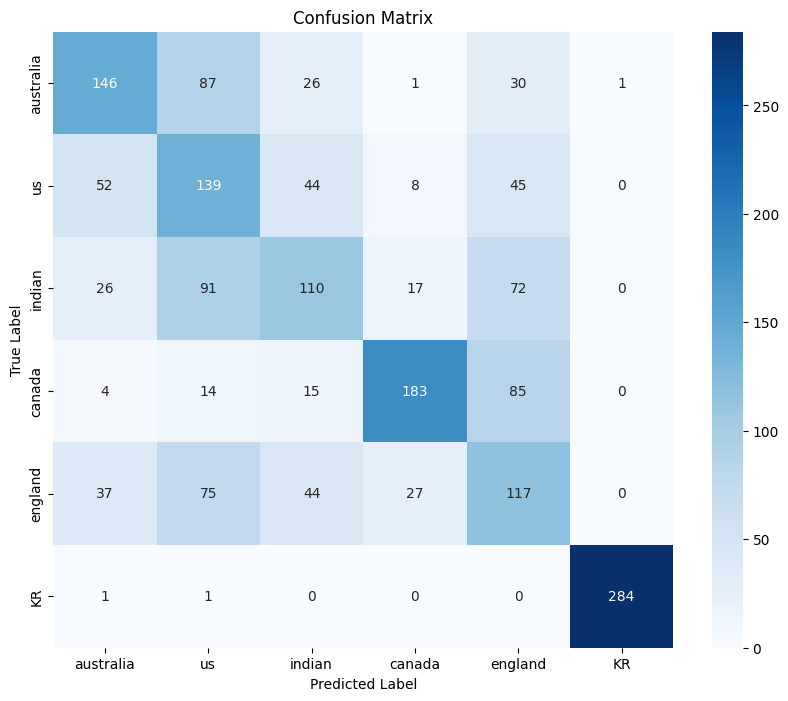

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

labels = ['australia', 'us','indian','canada', 'england', 'KR']

# 그래프 설정
plt.figure(figsize=(10, 8))
sns.heatmap(mt, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

print(f"test accuracy: {ltest_acc}")
print(f"test loss: {ltest_loss}")

# 축 레이블 설정
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
